In [3]:
from tensorflow import keras
print('keras: ', keras.__version__)

## Objectives
After completing this practical, I should be able to:
1. [Build a neural network model to classify movie reviews ](#demo)
2. [Exercise- tuning several model parameters](#exc)

## 1. Classifying movie reviews (a binary classification example)  <a id='demo' />

In this example, we will learn to classify movie reviews into "positive" reviews and "negative" reviews, just based on the text content of the reviews.

### 1.1 The IMDB dataset

The IMDB dataset has a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews.

The IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words)
have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

The following code will load the dataset (when you run it for the first time, about 80MB of data will be downloaded to your machine):

In [4]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17464789/17464789 [==============================] - 9s 1us/step


The argument `num_words=10000` means that we will only keep the top 10,000 most frequently occurring words in the training data. Rare words
will be discarded. This allows us to work with vector data of manageable size.

The variables `train_data` and `test_data` are lists of reviews, each review being a list of word indices (encoding a sequence of words).
`train_labels` and `test_labels` are lists of 0s and 1s, where 0 stands for "negative" and 1 stands for "positive":

In [5]:
import numpy as np

print(train_data[100])
print('\nthe length of this training sample is: ',len(train_data[100]))

train_labels[100]

[1, 13, 244, 6, 87, 337, 7, 628, 2219, 5, 28, 285, 15, 240, 93, 23, 288, 549, 18, 1455, 673, 4, 241, 534, 3635, 8448, 20, 38, 54, 13, 258, 46, 44, 14, 13, 1241, 7258, 12, 5, 5, 51, 9, 14, 45, 6, 762, 7, 2, 1309, 328, 5, 428, 2473, 15, 26, 1292, 5, 3939, 6728, 5, 1960, 279, 13, 92, 124, 803, 52, 21, 279, 14, 9, 43, 6, 762, 7, 595, 15, 16, 2, 23, 4, 1071, 467, 4, 403, 7, 628, 2219, 8, 97, 6, 171, 3596, 99, 387, 72, 97, 12, 788, 15, 13, 161, 459, 44, 4, 3939, 1101, 173, 21, 69, 8, 401, 2, 4, 481, 88, 61, 4731, 238, 28, 32, 11, 32, 14, 9, 6, 545, 1332, 766, 5, 203, 73, 28, 43, 77, 317, 11, 4, 2, 953, 270, 17, 6, 3616, 13, 545, 386, 25, 92, 1142, 129, 278, 23, 14, 241, 46, 7, 158]

the length of this training sample is:  158


0

Since we restricted ourselves to the top 10,000 most frequent words, no word index will exceed 10,000:

In [6]:
max(np.array([max(sequence) for sequence in train_data]))

9999

Just to try, here's how you can quickly decode one of these reviews back to English words:

In [8]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[100]])

decoded_review

1641221/1641221 [==============================] - 1s 0us/step


"? i am a great fan of david lynch and have everything that he's made on dvd except for hotel room the 2 hour twin peaks movie so when i found out about this i immediately grabbed it and and what is this it's a bunch of ? drawn black and white cartoons that are loud and foul mouthed and unfunny maybe i don't know what's good but maybe this is just a bunch of crap that was ? on the public under the name of david lynch to make a few bucks too let me make it clear that i didn't care about the foul language part but had to keep ? the sound because my neighbors might have all in all this is a highly disappointing release and may well have just been left in the ? box set as a curiosity i highly recommend you don't spend your money on this 2 out of 10"

### 1.2 Preparing the data

We cannot feed lists of integers into a neural network. We have to turn our lists into tensors. We use one-hot-encode to turn our lists into vectors of 0s and 1s.
For example, turning the sequence `[3, 5]` into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones.
Let's vectorize our data, which we will do manually for maximum clarity:

In [17]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

Here's what our samples look like now:

In [18]:
x_train.shape

x_train[100]

print('train_data[100] is: \n', train_data[100])
print('\n After one-hot-encode, train_data[100] is encoded to x_train[100]: \n', x_train[100])
print('\n The index of non-zero elements in x_train[100] are : \n', np.nonzero(x_train[100]))

train_data[100] is: 
 [1, 13, 244, 6, 87, 337, 7, 628, 2219, 5, 28, 285, 15, 240, 93, 23, 288, 549, 18, 1455, 673, 4, 241, 534, 3635, 8448, 20, 38, 54, 13, 258, 46, 44, 14, 13, 1241, 7258, 12, 5, 5, 51, 9, 14, 45, 6, 762, 7, 2, 1309, 328, 5, 428, 2473, 15, 26, 1292, 5, 3939, 6728, 5, 1960, 279, 13, 92, 124, 803, 52, 21, 279, 14, 9, 43, 6, 762, 7, 595, 15, 16, 2, 23, 4, 1071, 467, 4, 403, 7, 628, 2219, 8, 97, 6, 171, 3596, 99, 387, 72, 97, 12, 788, 15, 13, 161, 459, 44, 4, 3939, 1101, 173, 21, 69, 8, 401, 2, 4, 481, 88, 61, 4731, 238, 28, 32, 11, 32, 14, 9, 6, 545, 1332, 766, 5, 203, 73, 28, 43, 77, 317, 11, 4, 2, 953, 270, 17, 6, 3616, 13, 545, 386, 25, 92, 1142, 129, 278, 23, 14, 241, 46, 7, 158]

 After one-hot-encode, train_data[100] is encoded to x_train[100]: 
 [0. 1. 1. ... 0. 0. 0.]

 The index of non-zero elements in x_train[100] are : 
 (array([   1,    2,    4,    5,    6,    7,    8,    9,   11,   12,   13,
         14,   15,   16,   17,   18,   20,   21,   23,   25,   26,  

We should also vectorize our labels, which is straightforward:

In [19]:
train_labels[100]

# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

y_train[100]

0.0

Now our data is ready to be fed into a neural network.


### 1.3 Building our network


Our input data is simply vectors, and our labels are scalars (1s and 0s). Let's implement it in Keras.

In [20]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                160016    
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160305 (626.19 KB)
Trainable params: 160305 (626.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Lastly, we configure our model with the `rmsprop` optimizer and the `binary_crossentropy` loss function. Note that we will
also monitor accuracy during training.

In [24]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

We are passing our optimizer, loss function and metrics as strings, which is possible because `rmsprop`, `binary_crossentropy` and `accuracy` are packaged as part of Keras.

### 1.4 Validating our approach

In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a "validation set" by
setting apart 10,000 samples from the original training data:

In [25]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

We will now train our model for 20 epochs, in mini-batches of 512 samples. At same time we will monitor loss and accuracy on the 10,000 samples that we set apart. This is done by passing the validation data as the `validation_data` argument:

In [26]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 11s 302ms/step - loss: 0.5236 - acc: 0.7839 - val_loss: 0.3975 - val_acc: 0.8661
Epoch 2/20
30/30 [==============================] - 2s 63ms/step - loss: 0.3220 - acc: 0.8967 - val_loss: 0.3115 - val_acc: 0.8864
Epoch 3/20
30/30 [==============================] - 1s 34ms/step - loss: 0.2432 - acc: 0.9203 - val_loss: 0.2925 - val_acc: 0.8835
Epoch 4/20
30/30 [==============================] - 1s 28ms/step - loss: 0.1984 - acc: 0.9332 - val_loss: 0.3057 - val_acc: 0.8743
Epoch 5/20
30/30 [==============================] - 1s 23ms/step - loss: 0.1657 - acc: 0.9462 - val_loss: 0.3006 - val_acc: 0.8798
Epoch 6/20
30/30 [==============================] - 1s 38ms/step - loss: 0.1417 - acc: 0.9557 - val_loss: 0.3134 - val_acc: 0.8768
Epoch 7/20
30/30 [==============================] - 1s 28ms/step - loss: 0.1220 - acc: 0.9613 - val_loss: 0.3004 - val_acc: 0.8800
Epoch 8/20
30/30 [==============================] - 1s 37ms/step - loss: 0.1063 -

Note that the call to `model.fit()` returns a `history` object. This object has a member `history`, which is a dictionary containing data about everything that happened during training. Let's take a look at it:

In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

It contains 4 entries: one per metric that was being monitored, during training and during validation. Let's use Matplotlib to plot the
training and validation loss side by side, as well as the training and validation accuracy:

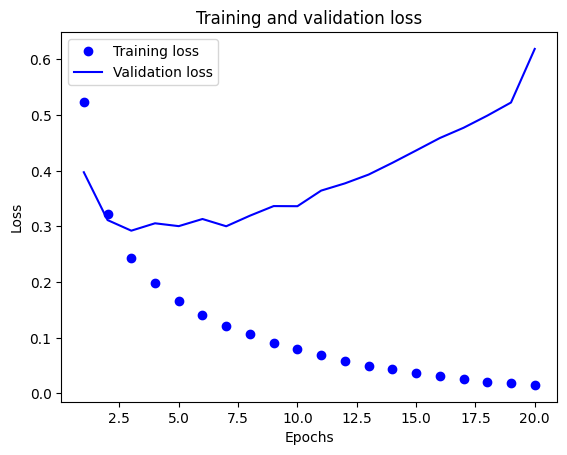

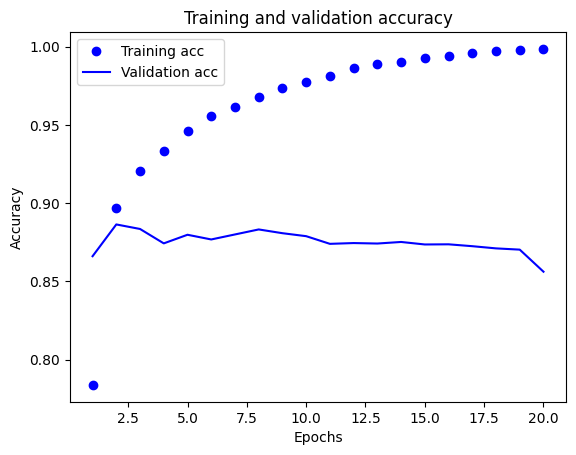

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()   # clear figure
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

The dots are the training loss and accuracy, while the solid lines are the validation loss and accuracy. As you can see, the training loss decreases with every epoch and the training accuracy increases with every epoch. That's what you would
expect when running gradient descent optimization -- the quantity you are trying to minimize should get lower with every iteration. But that isn't the case for the validation loss and accuracy: they seem to peak at the fourth epoch. A model that performs better on the training data isn't necessarily a model that will do better on data it has never seen before. What you are seeing is "overfitting": after the second epoch, we are over-optimizing on the training data, and we ended up learning representations that are specific to the training data and do not generalize to data outside of the training set.

In this case, to prevent overfitting, we could simply stop training after three epochs. Let's train a new network from scratch for four epochs, then evaluate it on our test data:

In [33]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

model.fit(x_train, y_train, epochs=4, batch_size=512)


results = model.evaluate(x_test, y_test, verbose=2)
results # returns the loss value and accuracy


Epoch 1/4
49/49 [==============================] - 1s 12ms/step - loss: 0.5133 - acc: 0.8064
Epoch 2/4
49/49 [==============================] - 1s 10ms/step - loss: 0.3102 - acc: 0.8928
Epoch 3/4
49/49 [==============================] - 1s 11ms/step - loss: 0.2411 - acc: 0.9136
Epoch 4/4
49/49 [==============================] - 1s 11ms/step - loss: 0.2040 - acc: 0.9261
782/782 - 2s - loss: 0.2850 - acc: 0.8856 - 2s/epoch - 2ms/step


[0.2849917709827423, 0.8855599761009216]

Our fairly naive approach achieves an accuracy of 88.56%. With state-of-the-art approaches, one should be able to get close to 95%.

### 1.5 Using a trained network to generate predictions on new data

After having trained a network, you will want to use it in a practical setting. You can generate the likelihood of reviews being positive
by using the `predict` method:


In [37]:
model.predict(x_test)

782/782 [==============================] - 1s 1ms/step


array([[0.01954212],
       [0.99852324],
       [0.85506445],
       ...,
       [0.00974065],
       [0.01171114],
       [0.8481086 ]], dtype=float32)

As you can see, the network is very confident for some samples (0.99 or more, or 0.01 or less) but less confident for others (0.6, 0.4).


## 2. Exercise - tuning model parameters <a id='demo' />
Please try to improve model performance by tuning below hyperparameters:
* number of layers
* number of units in each layer
* number of epochs
* activation function (e.g. change relu to sigmoid)
* Any other suitable hyperparameters

### In the below code I utilize the above parameters to achieve a higher validatoin accuracy, and maintain the accuracy loss curve.
I choose to:
 * lower the epochs so as to avoid overfitting, 
 * reduce the units per Dense layer,
 * reduce batch size,
 * and use a sigmoid acitivation for each layer.

In [39]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(8, activation='sigmoid', input_shape=(10000,)))
model.add(layers.Dense(8, activation='sigmoid'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 8)                 80008     
                                                                 
 dense_19 (Dense)            (None, 8)                 72        
                                                                 
 dense_20 (Dense)            (None, 1)                 9         
                                                                 
Total params: 80089 (312.85 KB)
Trainable params: 80089 (312.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/4
125/125 [==============================] - 9s 63ms/step - loss: 0.7837 - acc: 0.4965 - val_loss: 0.7031 - val_acc: 0.5053
Epoch 2/4
125/125 [==============================] - 2s 14ms/step - loss: 0.6901 - acc: 0.5280 - val_loss: 0.6709 - val_acc: 0.6136
Epoch 3/4
125/125 [==============================] - 1s 7ms/step - loss: 0.6245 - acc: 0.7042 - val_loss: 0.5753 - val_acc: 0.8126
Epoch 4/4
125/125 [==============================] - 1s 8ms/step - loss: 0.5224 - acc: 0.8487 - val_loss: 0.4821 - val_acc: 0.8547


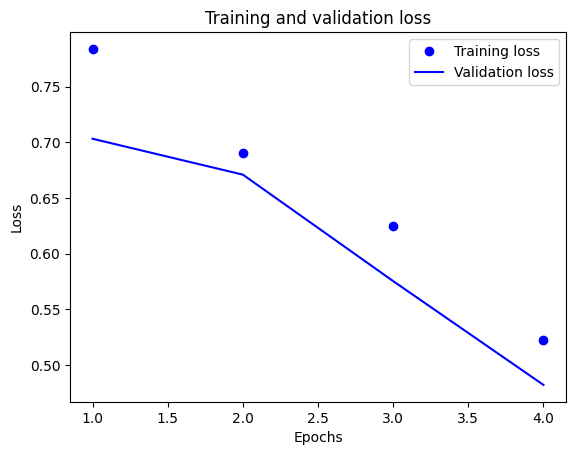

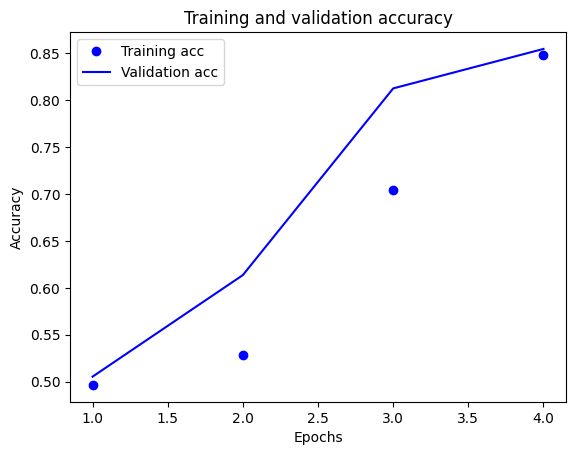

782/782 - 2s - loss: 0.4865 - acc: 0.8551 - 2s/epoch - 3ms/step


[0.4864792823791504, 0.8551200032234192]

In [40]:
# compiling and plotting graphs:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=4,
                    batch_size=120,
                    validation_data=(x_val, y_val))

history_dict = history.history
history_dict.keys()

import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()   # clear figure
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

results = model.evaluate(x_test, y_test, verbose=2)
results # returns the loss value and accuracy

In [41]:
model.predict(x_test)

782/782 [==============================] - 2s 2ms/step


array([[0.49347827],
       [0.8129099 ],
       [0.7326207 ],
       ...,
       [0.37549272],
       [0.40590012],
       [0.5475349 ]], dtype=float32)

Hence I manage to increase the confidence of the model for all reviews, but at the cost of spikes in confidence for only a set few reviews, which can be further improved through further testing.